In [1]:
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from uncertainties import ufloat
from ctypes import c_double

import ROOT
import math
ROOT.EnableImplicitMT()    # Tells ROOT to go parallel

/groups/hephy/cms/alikaan.gueven/conda/envs/SDV/lib/python3.11/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


Welcome to JupyROOT 6.28/00


In [2]:
import os

unique_dir = "SDVSecVtx_ParTScore"

# ------------------------------------------------
sig_tag  = 'stop_M600_585_ct20_2018'




histname = "MET_pt_corr_vs_Max_ML_score"
tdir     = "SP1_evt"
# tdir     = "all_evt"
# tdir     = "CP_evt"




bkg_dir = "/scratch-cbe/users/alikaan.gueven/AN_plots/ParT_hists/" + unique_dir + "/bkg"
sig_dir = "/scratch-cbe/users/alikaan.gueven/AN_plots/ParT_hists/" + unique_dir + "/sig"



sig_file = ROOT.TFile(os.path.join(sig_dir, f"{sig_tag}_hist.root"))
sig_dir  = getattr(sig_file, tdir)
sig_hist = getattr(sig_dir, histname).Clone()


bkg_file = ROOT.TFile(os.path.join(bkg_dir, f"all_2018_hist.root"))
bkg_dir  = getattr(bkg_file, tdir)
bkg_hist = getattr(bkg_dir, histname).Clone()

In [3]:
x_binwidth = sig_hist.GetXaxis().GetBinWidth(1)
y_binwidth = sig_hist.GetYaxis().GetBinWidth(1)

In [4]:
xax = sig_hist.GetXaxis()
yax = sig_hist.GetYaxis()

x_min = xax.GetBinLowEdge(1)
x_max = xax.GetBinUpEdge(xax.GetLast())

y_min = yax.GetBinLowEdge(1)
y_max = yax.GetBinUpEdge(yax.GetLast())

print(x_min, x_max, x_binwidth)
print(y_min, y_max, y_binwidth)

0.0 1000.0 50.0
0.0 1.0 0.002


In [5]:
MET_boundaryList     = np.arange(200   + x_binwidth, x_max, x_binwidth)
MLScore_boundaryList = np.arange(y_min + y_binwidth, y_max, y_binwidth)

In [6]:
MET_step = MET_boundaryList[1] - MET_boundaryList[0]
MLScore_step = MLScore_boundaryList[1] - MLScore_boundaryList[0]

# print(MET_boundaryList)
# print(MLScore_boundaryList)

MLScore_min = bkg_hist.GetYaxis().FindBin(0.50)

In [7]:
def calc_unc(region, region_unc, x_boundary, y_boundary, tables, noncl=None):
    unc1 = tables[region].loc[x_boundary, y_boundary] * 0.20
    unc2 = tables[region].loc[x_boundary, y_boundary] * noncl if noncl else 0.
    unc3 = tables[region_unc].loc[x_boundary, y_boundary]
    total_unc = np.sqrt(unc1**2 + unc2**2 + unc3**2)
    return total_unc

In [8]:
import numpy as np
from warnings import simplefilter
simplefilter(action="ignore", category=pd.errors.PerformanceWarning)
simplefilter(action="ignore", category=FutureWarning)

def makeTables(
        xedges: np.ndarray,
        yedges: np.ndarray,
        bkg_hist: ROOT.TH2,
        sig_hist: ROOT.TH2,
        x_loCut: float = 0.0,
        y_loCut: float = 0.0,
        sigScale: float = 1.0,
        bkgScale: float = 1.0,
):
    x_step = xedges[1] - xedges[0]
    y_step = yedges[1] - yedges[0]
    empty_df = pd.DataFrame(index=np.arange(xedges[0], xedges[-1]+x_step, x_step),
                            columns=np.arange(yedges[0], yedges[-1]+y_step, y_step),
                            dtype= float)

    # Create empty tables
    tableNames = ['sig_NA', 'sig_NB', 'sig_NC', 'sig_ND',
                  'bkg_NA', 'bkg_NB', 'bkg_NC', 'bkg_ND',
                  'sig_NA_unc', 'sig_NB_unc', 'sig_NC_unc', 'sig_ND_unc',
                  'bkg_NA_unc', 'bkg_NB_unc', 'bkg_NC_unc', 'bkg_ND_unc',
                  'Z_A', 'Z_B', 'Z_C', 'Z_D',
                  'Z_noncl_A', 'Z_noncl_B', 'Z_noncl_C', 'Z_noncl_D',
                  'Z_noncl_plus1s_A', 'Z_noncl_plus1s_B', 'Z_noncl_plus1s_C', 'Z_noncl_plus1s_D',
                  'noncl', 'noncl_unc',
                ]
    tables = dict()
    for name in tableNames:
        tables[name] = empty_df.copy()
     
    for x_boundary in xedges:
        for y_boundary in yedges:
            x_lo    = bkg_hist.GetXaxis().FindBin(x_loCut)
            x_up    = bkg_hist.GetNbinsX()+1
            x_bound = bkg_hist.GetXaxis().FindBin(x_boundary)

            y_lo    = bkg_hist.GetYaxis().FindBin(y_loCut)
            y_up    = bkg_hist.GetNbinsY()+1
            y_bound = bkg_hist.GetYaxis().FindBin(y_boundary)


            # ------------ Backgrounds --------------
            c_err = c_double(0.0)
            NA = ufloat(bkg_hist.IntegralAndError(x_bound,    x_up,       y_bound,    y_up,          c_err), c_err.value) * bkgScale
            NB = ufloat(bkg_hist.IntegralAndError(x_lo,       x_bound-1,  y_bound,    y_up,          c_err), c_err.value) * bkgScale
            NC = ufloat(bkg_hist.IntegralAndError(x_bound,    x_up,       y_lo,      y_bound-1,      c_err), c_err.value) * bkgScale
            ND = ufloat(bkg_hist.IntegralAndError(x_lo,       x_bound-1,  y_lo,      y_bound-1,      c_err), c_err.value) * bkgScale

            num   = NB * NC
            denom = NA * ND
            noncl = np.abs(1- num/denom) if denom.n > 0 else ufloat(1e-5, 1e-5)

            eps = 5e-1

            tables['bkg_NA'].loc[x_boundary, y_boundary] = max(eps, NA.n) # max: in case there are negative bins
            tables['bkg_NB'].loc[x_boundary, y_boundary] = max(eps, NB.n)
            tables['bkg_NC'].loc[x_boundary, y_boundary] = max(eps, NC.n)
            tables['bkg_ND'].loc[x_boundary, y_boundary] = max(eps, ND.n)

            tables['bkg_NA_unc'].loc[x_boundary, y_boundary] = max(eps, NA.s)
            tables['bkg_NB_unc'].loc[x_boundary, y_boundary] = max(eps, NB.s)
            tables['bkg_NC_unc'].loc[x_boundary, y_boundary] = max(eps, NC.s)
            tables['bkg_ND_unc'].loc[x_boundary, y_boundary] = max(eps, ND.s)

            tables['noncl'].loc[x_boundary, y_boundary]     = noncl.n
            tables['noncl_unc'].loc[x_boundary, y_boundary] = noncl.s
            

            # ------------ Signals --------------
            c_err = c_double(0.0)
            NA = ufloat(sig_hist.IntegralAndError(x_bound,    x_up,       y_bound,    y_up,          c_err), c_err.value) * sigScale
            NB = ufloat(sig_hist.IntegralAndError(x_lo,       x_bound-1,  y_bound,    y_up,          c_err), c_err.value) * sigScale
            NC = ufloat(sig_hist.IntegralAndError(x_bound,    x_up,       y_lo,      y_bound-1,      c_err), c_err.value) * sigScale
            ND = ufloat(sig_hist.IntegralAndError(x_lo,       x_bound-1,  y_lo,      y_bound-1,      c_err), c_err.value) * sigScale

            eps = 5e-1

            tables['sig_NA'].loc[x_boundary, y_boundary] = max(eps, NA.n) # max: in case there are negative bins
            tables['sig_NB'].loc[x_boundary, y_boundary] = max(eps, NB.n)
            tables['sig_NC'].loc[x_boundary, y_boundary] = max(eps, NC.n)
            tables['sig_ND'].loc[x_boundary, y_boundary] = max(eps, ND.n)

            tables['sig_NA_unc'].loc[x_boundary, y_boundary] = max(eps, NA.s)
            tables['sig_NB_unc'].loc[x_boundary, y_boundary] = max(eps, NB.s)
            tables['sig_NC_unc'].loc[x_boundary, y_boundary] = max(eps, NC.s)
            tables['sig_ND_unc'].loc[x_boundary, y_boundary] = max(eps, ND.s)

            # ------------ Significance --------------

            Z_A      = ROOT.RooStats.AsimovSignificance(tables['sig_NA'].loc[x_boundary, y_boundary],
                                                         tables['bkg_NA'].loc[x_boundary, y_boundary],
                                                         calc_unc('bkg_NA', 'bkg_NA_unc', x_boundary, y_boundary, tables))
            Z_B      = ROOT.RooStats.AsimovSignificance(tables['sig_NB'].loc[x_boundary, y_boundary],
                                                         tables['bkg_NB'].loc[x_boundary, y_boundary],
                                                         calc_unc('bkg_NB', 'bkg_NB_unc', x_boundary, y_boundary, tables))
            Z_C      = ROOT.RooStats.AsimovSignificance(tables['sig_NC'].loc[x_boundary, y_boundary],
                                                         tables['bkg_NC'].loc[x_boundary, y_boundary],
                                                         calc_unc('bkg_NC', 'bkg_NC_unc', x_boundary, y_boundary, tables))
            Z_D      = ROOT.RooStats.AsimovSignificance(tables['sig_ND'].loc[x_boundary, y_boundary],
                                                         tables['bkg_ND'].loc[x_boundary, y_boundary],
                                                         calc_unc('bkg_ND', 'bkg_ND_unc', x_boundary, y_boundary, tables))

            
            tables['Z_A'].loc[x_boundary, y_boundary] = Z_A
            tables['Z_B'].loc[x_boundary, y_boundary] = Z_B
            tables['Z_C'].loc[x_boundary, y_boundary] = Z_C
            tables['Z_D'].loc[x_boundary, y_boundary] = Z_D

            # ------------ Significance with non-clsoure uncertainty --------------

            Z_A      = ROOT.RooStats.AsimovSignificance(tables['sig_NA'].loc[x_boundary, y_boundary],
                                                         tables['bkg_NA'].loc[x_boundary, y_boundary],
                                                         calc_unc('bkg_NA', 'bkg_NA_unc', x_boundary, y_boundary, tables, noncl.n))
            Z_B      = ROOT.RooStats.AsimovSignificance(tables['sig_NB'].loc[x_boundary, y_boundary],
                                                         tables['bkg_NB'].loc[x_boundary, y_boundary],
                                                         calc_unc('bkg_NB', 'bkg_NB_unc', x_boundary, y_boundary, tables, noncl.n))
            Z_C      = ROOT.RooStats.AsimovSignificance(tables['sig_NC'].loc[x_boundary, y_boundary],
                                                         tables['bkg_NC'].loc[x_boundary, y_boundary],
                                                         calc_unc('bkg_NC', 'bkg_NC_unc', x_boundary, y_boundary, tables, noncl.n))
            Z_D      = ROOT.RooStats.AsimovSignificance(tables['sig_ND'].loc[x_boundary, y_boundary],
                                                         tables['bkg_ND'].loc[x_boundary, y_boundary],
                                                         calc_unc('bkg_ND', 'bkg_ND_unc', x_boundary, y_boundary, tables, noncl.n))

            
            tables['Z_noncl_A'].loc[x_boundary, y_boundary] = Z_A
            tables['Z_noncl_B'].loc[x_boundary, y_boundary] = Z_B
            tables['Z_noncl_C'].loc[x_boundary, y_boundary] = Z_C
            tables['Z_noncl_D'].loc[x_boundary, y_boundary] = Z_D

            # ------------ Significance with non-clsoure uncertainty plus one sigma unc. -------

            Z_A      = ROOT.RooStats.AsimovSignificance(tables['sig_NA'].loc[x_boundary, y_boundary],
                                                         tables['bkg_NA'].loc[x_boundary, y_boundary],
                                                         calc_unc('bkg_NA', 'bkg_NA_unc', x_boundary, y_boundary, tables, noncl.n + noncl.s))
            Z_B      = ROOT.RooStats.AsimovSignificance(tables['sig_NB'].loc[x_boundary, y_boundary],
                                                         tables['bkg_NB'].loc[x_boundary, y_boundary],
                                                         calc_unc('bkg_NB', 'bkg_NB_unc', x_boundary, y_boundary, tables, noncl.n + noncl.s))
            Z_C      = ROOT.RooStats.AsimovSignificance(tables['sig_NC'].loc[x_boundary, y_boundary],
                                                         tables['bkg_NC'].loc[x_boundary, y_boundary],
                                                         calc_unc('bkg_NC', 'bkg_NC_unc', x_boundary, y_boundary, tables, noncl.n + noncl.s))
            Z_D      = ROOT.RooStats.AsimovSignificance(tables['sig_ND'].loc[x_boundary, y_boundary],
                                                         tables['bkg_ND'].loc[x_boundary, y_boundary],
                                                         calc_unc('bkg_ND', 'bkg_ND_unc', x_boundary, y_boundary, tables, noncl.n + noncl.s))

            
            tables['Z_noncl_plus1s_A'].loc[x_boundary, y_boundary] = Z_A
            tables['Z_noncl_plus1s_B'].loc[x_boundary, y_boundary] = Z_B
            tables['Z_noncl_plus1s_C'].loc[x_boundary, y_boundary] = Z_C
            tables['Z_noncl_plus1s_D'].loc[x_boundary, y_boundary] = Z_D
            
    return tables

In [9]:
tables = makeTables(
    MET_boundaryList,
    MLScore_boundaryList,
    bkg_hist,
    sig_hist,
    x_loCut = x_min,
    y_loCut = y_min,
    sigScale = 1.0,
    bkgScale = 1.0,
)

/groups/hephy/cms/alikaan.gueven/conda/envs/SDV/lib/python3.11/site-packages/uncertainties/core.py:1024: UserWarning: Using UFloat objects with std_dev==0 may give unexpected results.
  warn("Using UFloat objects with std_dev==0 may give unexpected results.")


In [10]:
for key in tables.keys():
    print(key)

sig_NA
sig_NB
sig_NC
sig_ND
bkg_NA
bkg_NB
bkg_NC
bkg_ND
sig_NA_unc
sig_NB_unc
sig_NC_unc
sig_ND_unc
bkg_NA_unc
bkg_NB_unc
bkg_NC_unc
bkg_ND_unc
Z_A
Z_B
Z_C
Z_D
Z_noncl_A
Z_noncl_B
Z_noncl_C
Z_noncl_D
Z_noncl_plus1s_A
Z_noncl_plus1s_B
Z_noncl_plus1s_C
Z_noncl_plus1s_D
noncl
noncl_unc


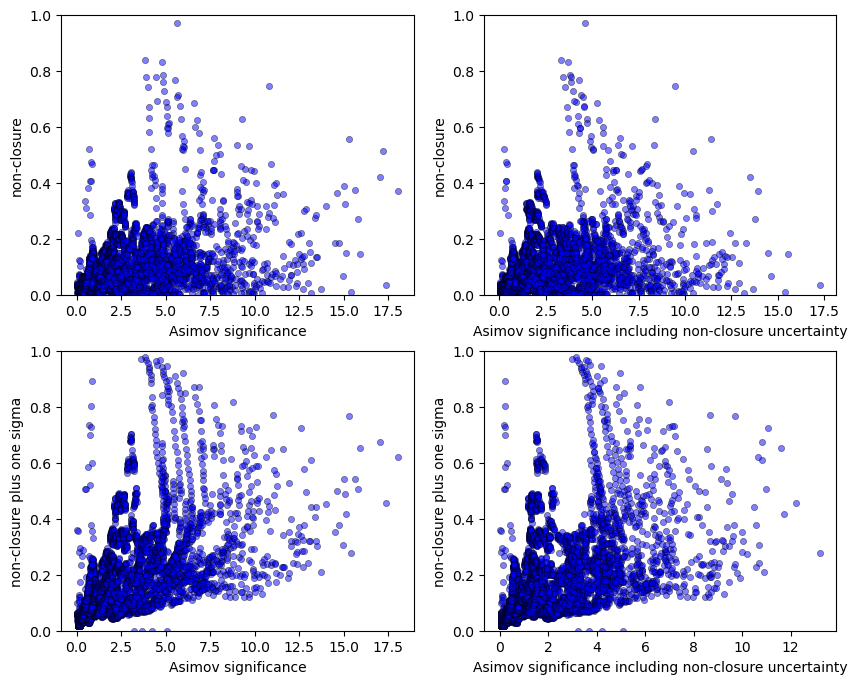

In [11]:
import matplotlib.pyplot as plt

noncl = tables['noncl']
noncl_plus1s = tables['noncl'] + tables['noncl_unc']

Z = tables['Z_A']
Z_noncl = tables['Z_noncl_A']
Z_noncl_plus1s = tables['Z_noncl_plus1s_A']

fig, axs = plt.subplots(2,2, figsize=(10,8))
for col in Z.columns:
    axs[0,0].scatter(Z[col], noncl[col], color="blue", alpha=0.5, s=20, edgecolors="k", linewidths=0.5)
axs[0,0].set_title("")
axs[0,0].set_ylim(0.0, 1.0)
axs[0,0].set_xlabel('Asimov significance')
axs[0,0].set_ylabel('non-closure')

for col in Z.columns:
    axs[1,0].scatter(Z[col], noncl_plus1s[col], color="blue", alpha=0.5, s=20, edgecolors="k", linewidths=0.5)
axs[1,0].set_title("")
axs[1,0].set_ylim(0.0, 1.0)
axs[1,0].set_xlabel('Asimov significance')
axs[1,0].set_ylabel('non-closure plus one sigma')

for col in Z.columns:
    axs[0,1].scatter(Z_noncl[col], noncl[col], color="blue", alpha=0.5, s=20, edgecolors="k", linewidths=0.5)
axs[0,1].set_title("")
axs[0,1].set_ylim(0.0, 1.0)
axs[0,1].set_xlabel('Asimov significance including non-closure uncertainty')
axs[0,1].set_ylabel('non-closure')

for col in Z.columns:
    axs[1,1].scatter(Z_noncl_plus1s[col], noncl_plus1s[col], color="blue", alpha=0.5, s=20, edgecolors="k", linewidths=0.5)
axs[1,1].set_title("")
axs[1,1].set_ylim(0.0, 1.0)
axs[1,1].set_xlabel('Asimov significance including non-closure uncertainty')
axs[1,1].set_ylabel('non-closure plus one sigma')

plt.show()


In [224]:
tables['sig_NA']

,0.002,0.004,0.006,0.008,0.010,0.012,0.014,0.016,0.018,0.020,...,0.980,0.982,0.984,0.986,0.988,0.990,0.992,0.994,0.996,0.998
250.0,754.450830,754.068419,753.765510,753.314736,752.941646,752.688736,752.626003,752.435884,752.309898,752.174683,...,456.270085,450.088202,443.639953,435.891483,425.453912,414.818823,400.289919,381.587879,353.432367,297.967249
300.0,581.637817,581.318763,581.015854,580.689556,580.434582,580.310146,580.247414,580.057295,579.994652,579.928465,...,354.916246,349.814921,344.633191,338.856297,330.352401,322.452184,310.957333,296.934815,274.984865,231.248700
350.0,439.461916,439.201532,438.898624,438.572326,438.377791,438.253356,438.190623,438.126577,438.063934,437.997746,...,270.634914,266.529529,262.756846,258.377674,251.610102,245.475000,236.779756,226.433507,210.011278,176.634364
400.0,335.273346,335.142013,334.896386,334.698432,334.570940,334.505326,334.505326,334.441279,334.378637,334.312449,...,206.958542,203.525347,200.925579,197.377823,192.372378,187.570974,180.751532,172.503198,159.138099,132.907536
450.0,254.541675,254.476079,254.294716,254.163708,254.099566,254.033952,254.033952,253.969905,253.969905,253.903718,...,157.208387,154.411358,152.324378,149.557414,145.665184,141.873438,136.767617,130.585173,120.281040,99.887899
500.0,194.019721,194.019721,193.900865,193.836027,193.771885,193.706271,193.706271,193.642224,193.642224,193.576037,...,120.585011,118.295236,116.769232,114.452174,111.754045,109.088919,105.269836,100.821122,93.381179,77.613505
550.0,144.993251,144.993251,144.930687,144.930687,144.930687,144.865073,144.865073,144.801026,144.801026,144.734838,...,90.642522,88.912393,87.973152,86.429269,84.433190,82.607913,79.531308,76.015678,70.479904,58.248742
600.0,109.359651,109.359651,109.297087,109.297087,109.297087,109.297087,109.297087,109.233040,109.233040,109.233040,...,68.253904,66.839662,66.134550,64.905324,63.289329,62.071711,59.740715,56.984645,52.802718,43.540171
650.0,83.715809,83.715809,83.653244,83.653244,83.653244,83.653244,83.653244,83.589197,83.589197,83.589197,...,52.605370,51.513586,51.003605,50.144737,49.034920,48.252170,46.431041,44.313465,41.011486,33.847550
700.0,63.859836,63.859836,63.859836,63.859836,63.859836,63.859836,63.859836,63.859836,63.859836,63.859836,...,39.278859,38.608152,38.161529,37.504642,36.717096,36.134122,34.729689,33.514677,30.631516,25.359093


In [225]:
noncl = tables['noncl']
noncl_plus1s = tables['noncl'] + tables['noncl_unc']

Z = tables['Z_A']
Z_noncl = tables['Z_noncl_A']
Z_noncl_plus1s = tables['Z_noncl_plus1s_A']

In [226]:
# import matplotlib.pyplot as plt

# plt.title(sig_tag)
# pcm = plt.pcolormesh(Z.index, Z.columns, Z.T, cmap='viridis')
# cbar = plt.colorbar(pcm)
# cbar.ax.set_ylabel('Asimov Significance')
# levels = [4, 8, 12]
# levels = [lv for lv in levels if lv <= np.nanmax(Z.values)]
# if levels:
#     cont = plt.contour(Z.index, Z.columns, Z.T, levels=levels, colors="white", linewidths=1.0)
#     plt.clabel(cont, fontsize="smaller")
# plt.ylim(0.9, 1.0)
# plt.xlabel('MET cut [GeV]')
# plt.ylabel('Max ParT score cut')
# plt.show()

In [227]:
# import matplotlib.pyplot as plt

# plt.title(sig_tag)
# pcm = plt.pcolormesh(Z_noncl.index, Z_noncl.columns, Z_noncl.T, cmap='viridis')
# cbar = plt.colorbar(pcm)
# cbar.ax.set_ylabel('Asimov Significance')
# levels = [4, 8, 12]
# levels = [lv for lv in levels if lv <= np.nanmax(Z.values)]
# if levels:
#     cont = plt.contour(Z_noncl.index, Z_noncl.columns, Z_noncl.T, levels=levels, colors="white", linewidths=1.0)
#     plt.clabel(cont, fontsize="smaller")
# plt.ylim(0.9, 1.0)
# plt.xlabel('MET cut [GeV]')
# plt.ylabel('Max ParT score cut')
# plt.show()

In [228]:
criterion = tables['Z_noncl_A'] > 15

pairs = list(zip(*np.where(criterion)))
pairs = [(tables['Z_noncl_A'].index[i], tables['Z_noncl_A'].columns[j]) for i, j in pairs]
for pair in pairs: print(pair)


(300.0, 0.998)
(500.0, 0.992)
(500.0, 0.996)


In [229]:
print(f"{2 * tables['bkg_NA'].loc[500.0, 0.996]:.3f}")



print(f"{10/6 * tables['bkg_NB'].loc[500.0, 0.996]:.3f}", end= " ")
print(f"{10/6 * tables['bkg_NC'].loc[500.0, 0.996]:.3f}", end= " ")
print(f"{10/6 * tables['bkg_ND'].loc[500.0, 0.996]:.3f}", end= " ")

2.625
184.676 5020.670 370471.791 

In [230]:
print(f"{10/6 * tables['sig_NA'].loc[500.0, 0.996]:.3f}", end= " ")
print(f"{10/6 * tables['sig_NB'].loc[500.0, 0.996]:.3f}", end= " ")
print(f"{10/6 * tables['sig_NC'].loc[500.0, 0.996]:.3f}", end= " ")
print(f"{10/6 * tables['sig_ND'].loc[500.0, 0.996]:.3f}", end= " ")

155.635 567.027 167.731 657.674 

In [231]:
print(f"{tables['noncl'].loc[500.0, 0.994]:.3f}")

0.151


### Significances (Z-score)

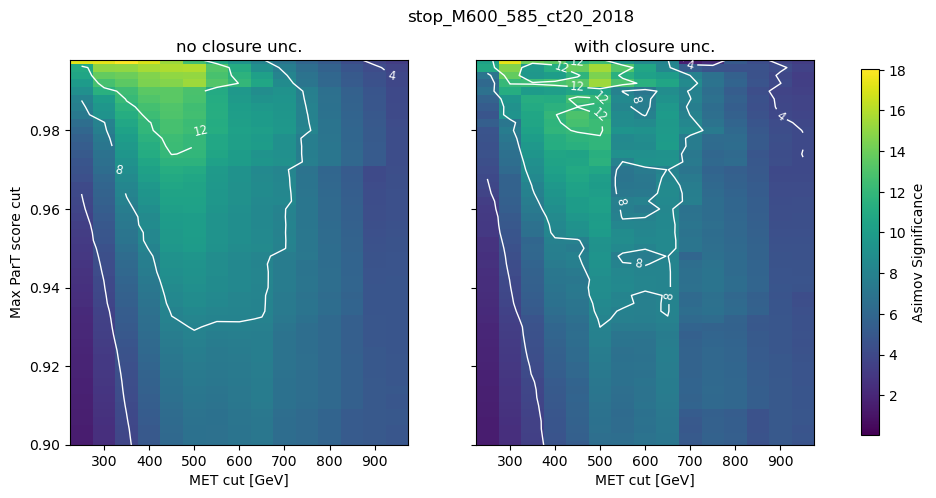

In [232]:
import numpy as np
import matplotlib.pyplot as plt

noncl = tables['noncl']
noncl_plus1s = tables['noncl'] + tables['noncl_unc']

Z = tables['Z_A']
Z_noncl = tables['Z_noncl_A']
Z_noncl_plus1s = tables['Z_noncl_plus1s_A']




# Common levels based on both matrices
base_levels = [4, 8, 12]
global_max = np.nanmax([np.nanmax(Z.values), np.nanmax(Z_noncl.values)])
levels = [lv for lv in base_levels if lv <= global_max]

# Consistent color scale across both plots
vmin = np.nanmin([np.nanmin(Z.values), np.nanmin(Z_noncl.values)])
vmax = global_max

fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

fig.suptitle(sig_tag)

# --- Left: Z ---
ax = axes[0]
ax.set_title(f"no closure unc.")
pcm0 = ax.pcolormesh(Z.index, Z.columns, Z.T, cmap='viridis', vmin=vmin, vmax=vmax, shading='auto')
if levels:
    cont0 = ax.contour(Z.index, Z.columns, Z.T, levels=levels, colors="white", linewidths=1.0)
    ax.clabel(cont0, fontsize="smaller")
ax.set_ylim(0.9, Z_noncl.columns.max())
ax.set_xlabel('MET cut [GeV]')
ax.set_ylabel('Max ParT score cut')

# --- Right: Z_noncl ---
ax = axes[1]
ax.set_title(f"with closure unc.")
pcm1 = ax.pcolormesh(Z_noncl.index, Z_noncl.columns, Z_noncl.T, cmap='viridis', vmin=vmin, vmax=vmax, shading='auto')
if levels:
    cont1 = ax.contour(Z_noncl.index, Z_noncl.columns, Z_noncl.T, levels=levels, colors="white", linewidths=1.0)
    ax.clabel(cont1, fontsize="smaller")
ax.set_ylim(0.9, Z_noncl.columns.max())
ax.set_xlabel('MET cut [GeV]')

# Shared colorbar
cbar = fig.colorbar(pcm1, ax=axes.ravel().tolist(), shrink=0.95)
cbar.ax.set_ylabel('Asimov Significance')

# plt.tight_layout()
plt.show()


### Non-closure ($\rlap{/}C$) maps

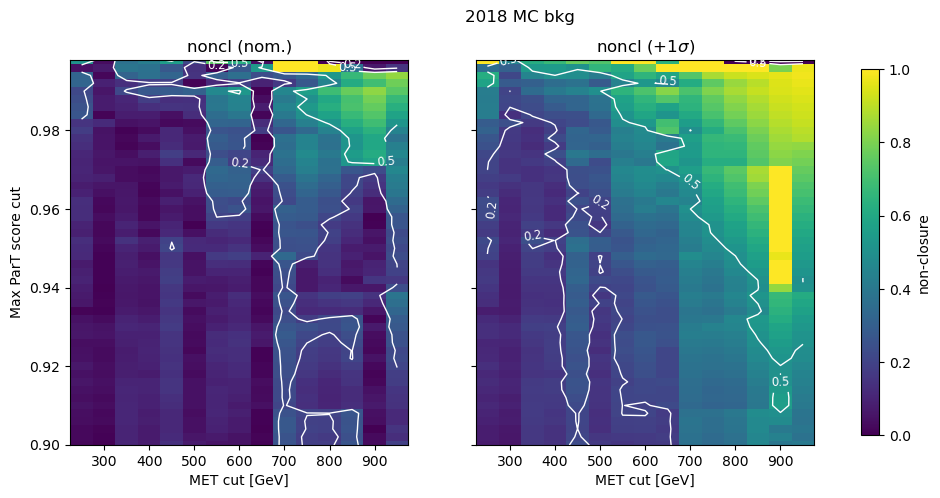

In [233]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

# --- noncl ---
Z   = tables['noncl']
Z1s = tables['noncl'] + tables['noncl_unc']

# Common levels based on both matrices
# Contour levels (clip to the data range so contour() doesn't warn)
base_levels = [0.20, 0.50]
zmax = max(np.nanmax(Z.values), np.nanmax(Z1s.values))
levels = [lv for lv in base_levels if lv <= zmax]

vmin = 0
vmax = 1

fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)
fig.suptitle("2018 MC bkg")

# --- Left: Z ---
ax = axes[0]
ax.set_title(r"noncl (nom.)")
pcm0 = ax.pcolormesh(Z.index, Z.columns, Z.T, cmap='viridis', vmin=vmin, vmax=vmax, shading='auto')
if levels:
    cont0 = ax.contour(Z.index, Z.columns, Z.T, levels=levels, colors="white", linewidths=1.0)
    ax.clabel(cont0, fontsize="smaller")
ax.set_ylim(0.9, Z_noncl.columns.max())
ax.set_xlabel('MET cut [GeV]')
ax.set_ylabel('Max ParT score cut')

# --- Right: Z_noncl ---
ax = axes[1]
ax.set_title(r"noncl (+1$\sigma$)")
pcm1 = ax.pcolormesh(Z1s.index, Z1s.columns, Z1s.T, cmap='viridis', vmin=vmin, vmax=vmax, shading='auto')
if levels:
    cont1 = ax.contour(Z1s.index, Z1s.columns, Z1s.T, levels=levels, colors="white", linewidths=1.0)
    ax.clabel(cont1, fontsize="smaller")
ax.set_ylim(0.9, Z_noncl.columns.max())
ax.set_xlabel('MET cut [GeV]')

# Shared colorbar
cbar = fig.colorbar(pcm1, ax=axes.ravel().tolist(), shrink=0.95)
cbar.ax.set_ylabel('non-closure')

# plt.tight_layout()
plt.show()


### Non-closure ($\rlap{/}C$) pull

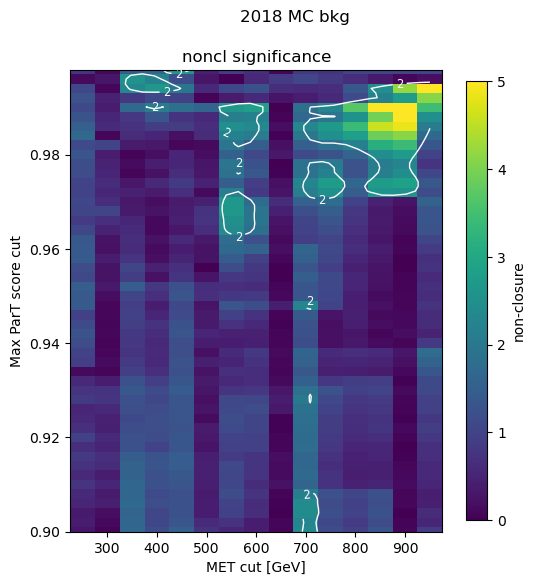

In [234]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import scipy.ndimage

# --- noncl ---
Z   = tables['noncl'] / tables['noncl_unc']

us = 2 # upsampling rate
Z_smooth = Z.loc[:,0.90:]
Z_smooth_x = scipy.ndimage.zoom(Z_smooth.index, us, mode='nearest')
Z_smooth_y = scipy.ndimage.zoom(Z_smooth.columns, us, mode='nearest')
Z_smooth = scipy.ndimage.zoom(Z_smooth, us)

# Common levels based on both matrices
# Contour levels (clip to the data range so contour() doesn't warn)
base_levels = [2] # 95.45 % CL
zmax = max(np.nanmax(Z.values), np.nanmax(Z1s.values))
levels = [lv for lv in base_levels if lv <= zmax]

vmin = 0
vmax = 5

fig, ax = plt.subplots(1,1, figsize=(6, 6), sharey=True)
fig.suptitle("2018 MC bkg")
ax.set_title(r"noncl significance")
pcm0 = ax.pcolormesh(Z.index, Z.columns, Z.T, cmap='viridis', vmin=vmin, vmax=vmax, shading='auto')
if levels:
    cont0 = ax.contour(Z_smooth_x, Z_smooth_y, Z_smooth.T, levels=levels, colors="white", linewidths=1)
    ax.clabel(cont0, fontsize="smaller")
ax.set_ylim(0.9, Z_noncl.columns.max())
ax.set_xlabel('MET cut [GeV]')
ax.set_ylabel('Max ParT score cut')

# Shared colorbar
cbar = fig.colorbar(pcm0, ax=ax, shrink=0.95)
cbar.ax.set_ylabel('non-closure')

# plt.tight_layout()
plt.show()


In [ ]:
# SP1_dict = {
#     'noncl': tables['noncl'],
#     'noncl_unc': tables['noncl_unc'],
# }

# CP_dict = {
#     'noncl': tables['noncl'],
#     'noncl_unc': tables['noncl_unc'],
# }

### Non-closure $\Delta \rlap{/}C$ pull

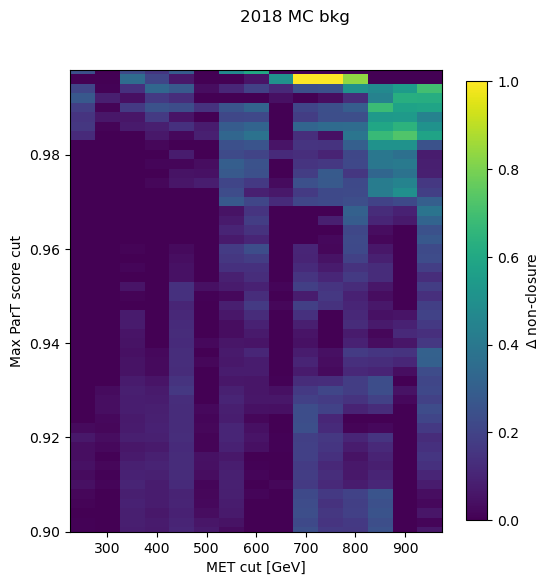

In [ ]:
# A = SP1_dict['noncl'] - CP_dict['noncl']

# vmin = 0
# vmax = 1

# fig, ax = plt.subplots(1,1, figsize=(6, 6), sharey=True)
# fig.suptitle("2018 MC bkg")
# ax.set_title(r"")
# pcm0 = ax.pcolormesh(A.index, A.columns, A.T, cmap='viridis', vmin=vmin, vmax=vmax, shading='auto')
# # if levels:
# #     cont0 = ax.contour(Z_smooth_x, Z_smooth_y, Z_smooth.T, levels=levels, colors="white", linewidths=1)
# #     ax.clabel(cont0, fontsize="smaller")
# ax.set_ylim(0.9, A.columns.max())
# ax.set_xlabel('MET cut [GeV]')
# ax.set_ylabel('Max ParT score cut')

# # Shared colorbar
# cbar = fig.colorbar(pcm0, ax=ax, shrink=0.95)
# cbar.ax.set_ylabel('$\Delta$ non-closure')

# # plt.tight_layout()
# plt.show()

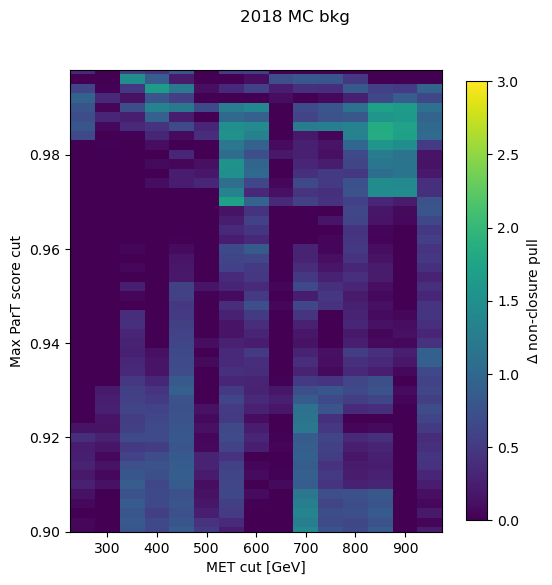

In [ ]:
# sp1 = SP1_dict['noncl']
# cp  = CP_dict['noncl']

# sp1_s = SP1_dict['noncl_unc']
# cp_s  = CP_dict['noncl_unc']



# A = sp1 - cp
# A_unc = np.hypot(sp1_s, cp_s)

# A = A / A_unc

# vmin = 0
# vmax = 3

# fig, ax = plt.subplots(1,1, figsize=(6, 6), sharey=True)
# fig.suptitle("2018 MC bkg")
# ax.set_title(r"")
# pcm0 = ax.pcolormesh(A.index, A.columns, A.T, cmap='viridis', vmin=vmin, vmax=vmax, shading='auto')
# # if levels:
# #     cont0 = ax.contour(Z_smooth_x, Z_smooth_y, Z_smooth.T, levels=levels, colors="white", linewidths=1)
# #     ax.clabel(cont0, fontsize="smaller")
# ax.set_ylim(0.9, A.columns.max())
# ax.set_xlabel('MET cut [GeV]')
# ax.set_ylabel('Max ParT score cut')

# # Shared colorbar
# cbar = fig.colorbar(pcm0, ax=ax, shrink=0.95)
# cbar.ax.set_ylabel('$\Delta$ non-closure pull')

# # plt.tight_layout()
# plt.show()

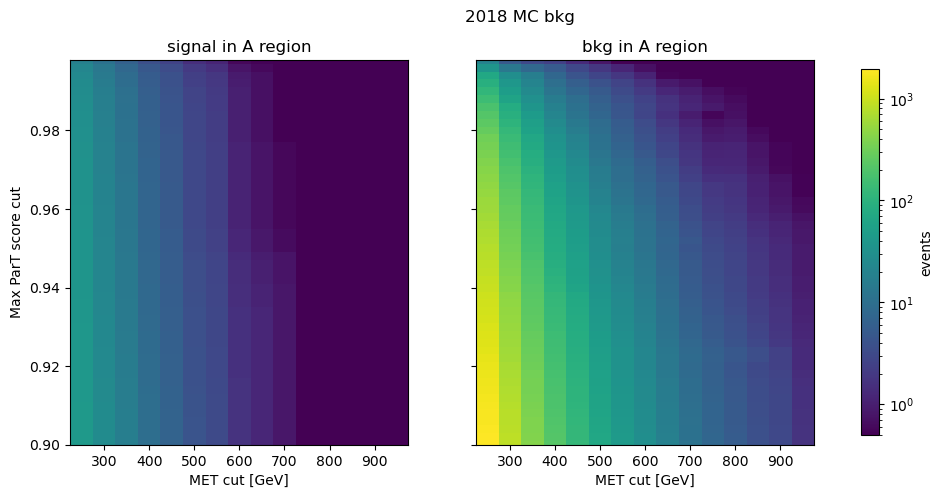

In [182]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

y_min = 0.90
sig_A = tables['sig_NA'].loc[:, y_min:]
bkg_A = tables['bkg_NA'].loc[:, y_min:]

# Shared normalization across both plots
vmin = min(sig_A.min().min(), bkg_A.min().min())
vmax = max(sig_A.max().max(), bkg_A.max().max())
norm = LogNorm(vmin=max(vmin, 1e-3), vmax=vmax)  # guard against zeros

fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)
fig.suptitle("2018 MC bkg")

# --- Left: sig_A ---
ax = axes[0]
ax.set_title("signal in A region")
pcm0 = ax.pcolormesh(sig_A.index, sig_A.columns, sig_A.T,
                     cmap='viridis', shading='auto', norm=norm)
ax.set_ylim(y_min, sig_A.columns.max())
ax.set_xlabel('MET cut [GeV]')
ax.set_ylabel('Max ParT score cut')

# --- Right: bkg_A ---
ax = axes[1]
ax.set_title("bkg in A region")
pcm1 = ax.pcolormesh(bkg_A.index, bkg_A.columns, bkg_A.T,
                     cmap='viridis', shading='auto', norm=norm)
ax.set_ylim(y_min, bkg_A.columns.max())
ax.set_xlabel('MET cut [GeV]')

# Shared colorbar (both share the same norm)
cbar = fig.colorbar(pcm1, ax=axes, shrink=0.95)
cbar.ax.set_ylabel('events')

plt.show()


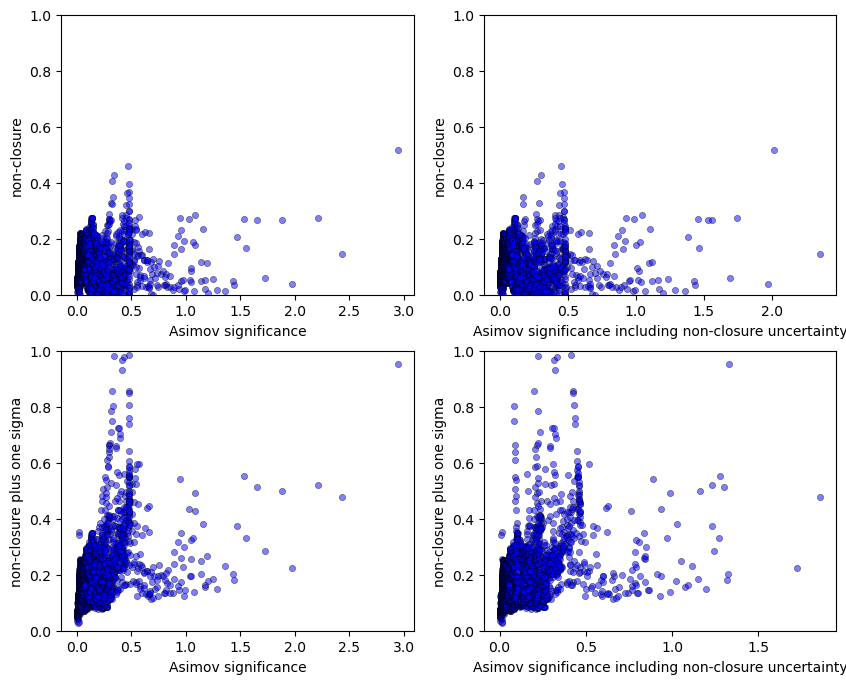

In [183]:
import matplotlib.pyplot as plt

noncl = tables['noncl']
noncl_plus1s = tables['noncl'] + tables['noncl_unc']

Z = tables['Z_A']
Z_noncl = tables['Z_noncl_A']
Z_noncl_plus1s = tables['Z_noncl_plus1s_A']

fig, axs = plt.subplots(2,2, figsize=(10,8))
for col in Z.columns:
    axs[0,0].scatter(Z[col], noncl[col], color="blue", alpha=0.5, s=20, edgecolors="k", linewidths=0.5)
axs[0,0].set_title("")
axs[0,0].set_ylim(0.0, 1.0)
axs[0,0].set_xlabel('Asimov significance')
axs[0,0].set_ylabel('non-closure')

for col in Z.columns:
    axs[1,0].scatter(Z[col], noncl_plus1s[col], color="blue", alpha=0.5, s=20, edgecolors="k", linewidths=0.5)
axs[1,0].set_title("")
axs[1,0].set_ylim(0.0, 1.0)
axs[1,0].set_xlabel('Asimov significance')
axs[1,0].set_ylabel('non-closure plus one sigma')

for col in Z.columns:
    axs[0,1].scatter(Z_noncl[col], noncl[col], color="blue", alpha=0.5, s=20, edgecolors="k", linewidths=0.5)
axs[0,1].set_title("")
axs[0,1].set_ylim(0.0, 1.0)
axs[0,1].set_xlabel('Asimov significance including non-closure uncertainty')
axs[0,1].set_ylabel('non-closure')

for col in Z.columns:
    axs[1,1].scatter(Z_noncl_plus1s[col], noncl_plus1s[col], color="blue", alpha=0.5, s=20, edgecolors="k", linewidths=0.5)
axs[1,1].set_title("")
axs[1,1].set_ylim(0.0, 1.0)
axs[1,1].set_xlabel('Asimov significance including non-closure uncertainty')
axs[1,1].set_ylabel('non-closure plus one sigma')

plt.show()


In [184]:
# noncl_plus1s
# import matplotlib.pyplot as plt
# for col in Z.columns:
#     plt.scatter(Z[col], noncl_plus1s[col], color="blue", alpha=0.5, s=20, edgecolors="k", linewidths=0.5)
# plt.xlabel('significance')
# plt.ylabel('non-closure')
# plt.ylim(0.0, 1.0)
# plt.show()

In [185]:
# noncl_plus1s
# import matplotlib.pyplot as plt
# for col in Z.columns:
#     plt.scatter(Z_noncl[col], noncl[col], color="blue", alpha=0.5, s=20, edgecolors="k", linewidths=0.5)
# plt.xlabel('significance')
# plt.ylabel('non-closure')
# plt.ylim(0.0, 1.0)
# plt.show()

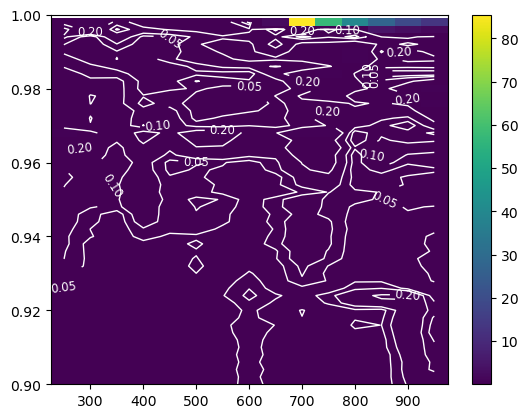

In [186]:
import matplotlib.pyplot as plt
noncl = tables['noncl']

pcm = plt.pcolormesh(noncl.index, noncl.columns, noncl.T, cmap='viridis')
cbar = plt.colorbar(pcm)
# plt.clim(0, 0.50)
levels = [0.05, 0.10, 0.20]
levels = [lv for lv in levels if lv <= np.nanmax(noncl.values)]
if levels:
    cont = plt.contour(noncl.index, noncl.columns, noncl.T, levels=levels, colors="white", linewidths=1.0)
    plt.clabel(cont, fontsize="smaller")
plt.ylim(0.9, 1.0)
plt.show()

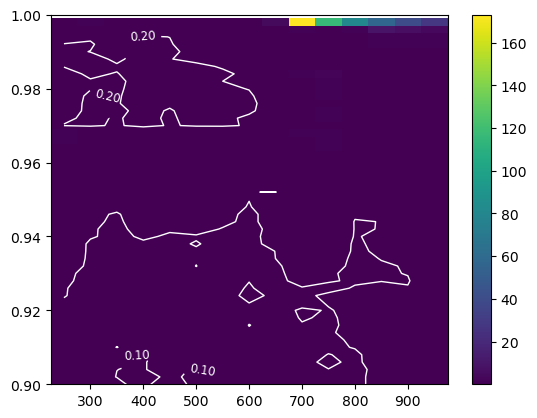

In [187]:
import matplotlib.pyplot as plt
noncl = tables['noncl'] + tables['noncl_unc']
pcm = plt.pcolormesh(noncl.index, noncl.columns, noncl.T, cmap='viridis')
cbar = plt.colorbar(pcm)
# plt.clim(0, 0.50)
levels = [0.05, 0.10, 0.20]
levels = [lv for lv in levels if lv <= np.nanmax(noncl.values)]
if levels:
    cont = plt.contour(noncl.index, noncl.columns, noncl.T, levels=levels, colors="white", linewidths=1.0)
    plt.clabel(cont, fontsize="smaller")
plt.ylim(0.9, 1.0)
plt.show()

### Scan lower boundary as well 

In [188]:
y_loCut = [0.00, 0.30, 0.50, 0.80]
myDict = dict()
for y_cut in y_loCut:
    tables = makeTables(
        MET_boundaryList,
        MLScore_boundaryList,
        bkg_hist,
        sig_hist,
        x_loCut = x_min,
        y_loCut = y_cut,
        sigScale = 1.0,
        bkgScale = 1.0,
    )
    myDict[f"{y_cut:.2f}"] = tables

/groups/hephy/cms/alikaan.gueven/conda/envs/SDV/lib/python3.11/site-packages/uncertainties/core.py:1024: UserWarning: Using UFloat objects with std_dev==0 may give unexpected results.
  warn("Using UFloat objects with std_dev==0 may give unexpected results.")


KeyboardInterrupt: 

In [ ]:
myDict['0.50']['noncl'].loc[:, float('0.50'):]

,0.500,0.502,0.504,0.506,0.508,0.510,0.512,0.514,0.516,0.518,...,0.980,0.982,0.984,0.986,0.988,0.990,0.992,0.994,0.996,0.998
250.0,0.0,0.040348,0.062664,0.073497,0.039508,0.008051,0.047423,0.072859,0.084457,0.065218,...,0.189479,0.164276,0.276426,0.265760,0.247108,0.230840,0.337742,0.331751,0.050889,0.526565
300.0,0.0,0.023261,0.060255,0.043226,0.068262,0.014080,0.022405,0.016484,0.008824,0.026406,...,0.056970,0.128066,0.016043,0.083798,0.082614,0.064731,0.081949,0.026789,0.075120,0.042574
350.0,0.0,0.030676,0.003137,0.037572,0.080842,0.067013,0.032735,0.030856,0.021489,0.035791,...,0.032584,0.080756,0.113765,0.128898,0.140323,0.246812,0.168412,0.342547,0.412550,0.392584
400.0,0.0,0.004330,0.005134,0.091239,0.107871,0.025702,0.006070,0.015750,0.032637,0.049424,...,0.002789,0.080389,0.108373,0.160913,0.208799,0.295674,0.208246,0.383742,0.391985,0.437224
450.0,0.0,0.014584,0.079841,0.095896,0.072865,0.005834,0.089404,0.041092,0.024077,0.049529,...,0.060554,0.026232,0.085159,0.190921,0.176087,0.318634,0.222570,0.354157,0.304922,0.576924
500.0,0.0,0.132822,0.133693,0.196069,0.156052,0.153673,0.037608,0.061556,0.098719,0.087707,...,0.002447,0.066246,0.160623,0.177225,0.170134,0.332314,0.047393,0.182104,0.102618,0.174597
550.0,0.0,0.001290,0.042397,0.012421,0.088494,0.111899,0.017026,0.014318,0.007377,0.002321,...,0.271706,0.332731,0.366039,0.408212,0.401834,0.477876,0.127202,0.307781,0.007241,0.721504
600.0,0.0,0.160629,0.042776,0.053770,0.226048,0.192988,0.124545,0.139936,0.072827,0.078581,...,0.263888,0.333839,0.412302,0.454994,0.460672,0.541312,0.206614,0.373871,0.287710,0.596713
650.0,0.0,0.154804,0.218574,0.009510,0.133564,0.140155,0.045691,0.061201,0.006501,0.011151,...,0.155451,0.100049,0.035398,0.098903,0.012083,0.019901,0.113228,0.250330,0.504291,0.014153
700.0,0.0,0.235194,0.056339,0.202733,0.346174,0.294773,0.229784,0.172345,0.158926,0.148150,...,0.296476,0.361113,0.430735,0.474454,0.436395,0.483994,0.203029,0.301464,1.332545,5.170943


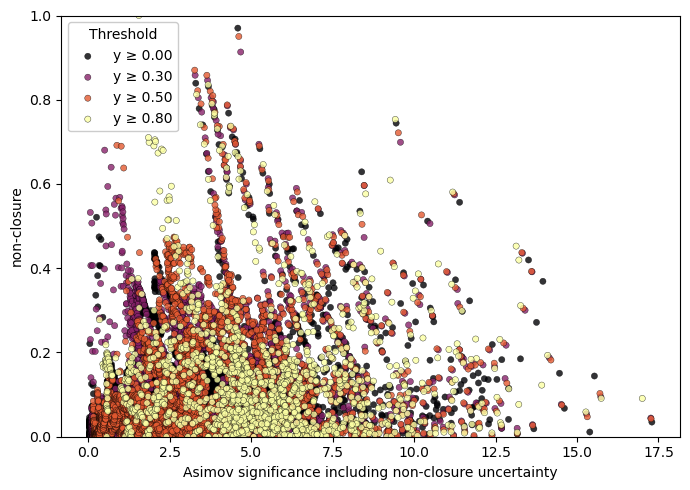

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize


keys = myDict.keys()
ylos = [float(ylo) for ylo in keys]
norm = Normalize(vmin=min(ylos), vmax=max(ylos))

plt.figure(figsize=(7,5))

for ylo in myDict.keys():
    noncl = myDict[ylo]['noncl'].loc[:, float(ylo):]
    Z     = myDict[ylo]['Z_noncl_A']  .loc[:, float(ylo):]

    # Flatten all columns so we do one scatter per ylo (clean legend)
    x = Z.to_numpy().ravel(order='F')
    y = noncl.to_numpy().ravel(order='F')

    plt.scatter(
        x, y,
        alpha=0.8,
        c=np.ones_like(x) * float(ylo),
        s=20,
        edgecolors="k",
        linewidths=0.3,
        label=f"y ≥ {ylo}",
        cmap='inferno',
        norm=norm
    )

plt.title("")
plt.xlabel("Asimov significance including non-closure uncertainty")
plt.ylabel("non-closure")
plt.ylim(0.0, 1.0)
plt.legend(title="Threshold", frameon=True, loc='upper left', framealpha=1.0)
plt.tight_layout()
plt.show()


In [1]:
def moving_average(a, n=3):
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

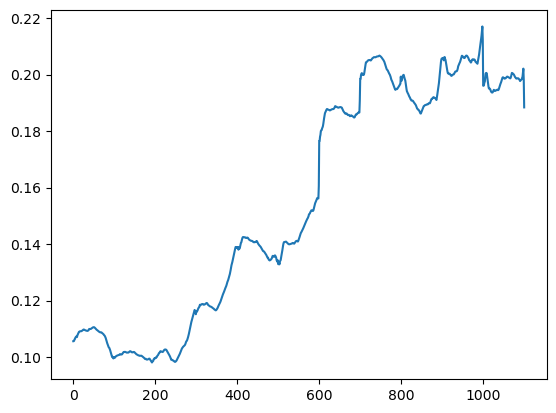

In [16]:
x = myDict[ylo]['noncl'].loc[:, float(ylo):].to_numpy().ravel()
y = moving_average(x, n=400)
leny = np.size(y)
plt.plot(y)

In [17]:
Z = myDict[ylo]['Z_A'].loc[:, float(ylo):].to_numpy().ravel()
Z

array([0.5706574 , 0.57568562, 0.58161664, ..., 3.85396182, 3.63026205,
       3.2364895 ])

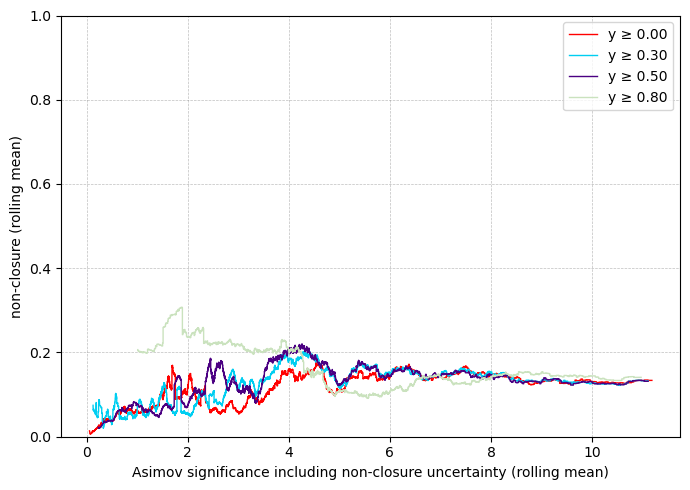

In [21]:
import numpy as np
import matplotlib.pyplot as plt

CB_color_cycle = ['red', '#00CEF1', 'indigo', '#CAE2BE']


plt.figure(figsize=(7,5))
for i, ylo in enumerate(myDict.keys()):
    # Flatten significance (X) and non-closure (Y)
    X = myDict[ylo]['Z_noncl_A']  .loc[:, float(ylo):].to_numpy().ravel(order='F')  # significance
    Y = myDict[ylo]['noncl'].loc[:, float(ylo):].to_numpy().ravel(order='F')  # non-closure

    # Drop NaNs and sort by significance
    m = np.isfinite(X) & np.isfinite(Y)
    X, Y = X[m], Y[m]
    order = np.argsort(X)
    Xs, Ys = X[order], Y[order]

    # Rolling mean with the SAME window on both X and Y
    n = 100  # your window
    kernel = np.ones(n) / n
    X_mean = np.convolve(Xs, kernel, mode='valid')
    Y_mean = np.convolve(Ys, kernel, mode='valid')
    plt.step(X_mean, Y_mean, lw=1., label=f"y ≥ {ylo}", color=CB_color_cycle[i])


from matplotlib import patheffects
plt.xlabel("Asimov significance including non-closure uncertainty (rolling mean)")
plt.ylabel("non-closure (rolling mean)")
plt.ylim(0, 1)
plt.tight_layout()
plt.legend()
plt.grid(color='gray', linestyle='dashed', alpha=0.5, lw=.5)
# plt.title('vtx_PART_770_epoch_83')
plt.show()
